In [72]:
import json
import os
from pathlib import Path
from html.parser import HTMLParser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

## Data Preprocessing

In [6]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return "".join(self.fed)


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(" ")[-1].replace(")", ""))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = " "
        new_line = "".join(new_line)
        return read_json_line(line=new_line)
    return result

def extract_tags(content):
    tags_str = []
    soup = BeautifulSoup(content, 'lxml')
    try:
        tag_block = soup.find('ul', class_='tags')
        tags = tag_block.find_all('a')
        for tag in tags:
            tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
        tags = ' '.join(tags_str)
    except Exception:
        tags = ''
    return tags

from tqdm import tqdm

tqdm.pandas()

def extract_features(path_to_data):
    content_list = []
    published_list = []
    title_list = []
    author_list = []
    domain_list = []
    url_list = []
    tags_list = []

    with open(path_to_data, encoding='utf-8') as f:
        for line in tqdm(f, desc="Processing Lines", leave=True):
            data = read_json_line(line)

            content = data['content'].replace('\n', ' ').replace('\r', ' ')
            content_stripped = strip_tags(content)
            content_list.append(content_stripped)

            published = data['published']['$date']
            published_list.append(published)

            title = data['meta_tags']['title'].split('\u2013')[0].strip()
            title_list.append(title)

            author = data['meta_tags']['title'].strip()
            author_list.append(author)

            domain = data['domain']
            domain_list.append(domain)

            url = data['url']
            url_list.append(url)

            tags = extract_tags(content)
            tags_list.append(tags)

    return content_list, published_list, title_list, author_list, domain_list, url_list, tags_list
    

### Paths

In [82]:
PATH_TO_TRAIN = Path("../../_static/data/assignment6/train.json")
PATH_TO_TEST = Path("../../_static/data/assignment6/test.json")
PATH_TO_TRAIN_TARGET = Path("../../_static/data/assignment6/train_log1p_recommends.csv")
PATH_TO_TEST_TARGET = Path("../../_static/data/assignment6/test_log1p_recommends.csv")
PATH_TO_SAMPLE_SUBMISSION = Path("../../_static/data/assignment6/sample_submission.csv")

### Reading Data

In [12]:
content_list, published_list, title_list, author_list, domain_list, url_list, tags_list = extract_features(PATH_TO_TRAIN)
train = pd.DataFrame()
train['content'] = content_list
train['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
train['title'] = title_list
train['author'] = author_list
train['domain'] = domain_list
train['url'] = url_list
train['tags'] = tags_list
train.head()

Processing Lines: 62313it [10:01, 103.54it/s]


,content,published,title,author,domain,url,tags
0,"MediumEveryone’s stories and ideasAug 13, 2012...",2012-08-13 22:54:53.510,Medium Terms of Service,Medium Terms of Service – Medium Policy – Medium,medium.com,https://medium.com/policy/medium-terms-of-serv...,TermsAndConditions Terms Medium
1,"MediumEveryone’s stories and ideasAug 2, 2015 ...",2015-08-03 07:44:50.331,Amendment to Medium Terms of Service Applicabl...,Amendment to Medium Terms of Service Applicabl...,medium.com,https://medium.com/policy/amendment-to-medium-...,
2,"Yun-Chen Chien（簡韻真）Nobody in @g0v.tw, PM in se...",2017-02-05 13:08:17.410,走入山與海之間：閩東大刀會和兩岸走私,走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium,medium.com,https://medium.com/@aelcenganda/%E9%96%A9%E6%9...,田野 歷史 閩東 大刀會 走私
3,Vaibhav KhulbeAndroid App Developer | I write ...,2017-05-06 08:16:30.776,How fast can a camera get?,How fast can a camera get? – What comes to min...,medium.com,https://medium.com/what-comes-to-mind/how-fast...,Photography Cameras Tech MIT Science
4,Vaibhav KhulbeAndroid App Developer | I write ...,2017-06-04 14:46:25.772,A game for the lonely fox,A game for the lonely fox – What comes to mind...,medium.com,https://medium.com/what-comes-to-mind/a-game-f...,Gaming Games AndroidGames GooglePlayStore Alone


In [13]:
content_list, published_list, title_list, author_list, domain_list, url_list, tags_list = extract_features(PATH_TO_TEST)
test = pd.DataFrame()
test['content'] = content_list
test['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
test['title'] = title_list
test['author'] = author_list
test['domain'] = domain_list
test['url'] = url_list
test['tags'] = tags_list
test.head(10)

Processing Lines: 34645it [05:44, 100.58it/s]


,content,published,title,author,domain,url,tags
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...","For Night Owls, the Day Starts with a Nocturna...",medium.com,https://medium.com/on-mornings/nocturnalmornin...,MorningRoutines Hitrecord Podcast Night
1,Member previewMaria Bustillosis a journalist a...,2017-12-07 15:56:00.967,Blockchain is Memory,Blockchain is Memory – Words That Matter – Medium,medium.com,https://medium.com/wordsthatmatter/never-break...,Blockchain Technology History Network WordsTha...
2,HITRECORDhitrecord.org is a new kind of online...,2018-02-08 17:33:27.816,ON MORNINGS Credits,ON MORNINGS Credits – On Mornings – Medium,medium.com,https://medium.com/on-mornings/onmorningscredi...,Medium Hitrecord OnMornings
3,"Member previewLance UlanoffTech expert, journa...",2018-02-09 18:04:12.262,Apple HomePod Review: Almost love,Apple HomePod Review: Almost love – Lance Ulan...,medium.com,https://medium.com/@LanceUlanoff/apple-homepod...,Apple Homepod Technology Review Audio
4,"MediumEveryone’s stories and ideasOct 2, 2017T...",2017-10-02 23:08:00.000,Tips and tricks for Medium writers,Tips and tricks for Medium writers – 3 min read,blog.medium.com,https://blog.medium.com/tips-and-tricks-for-me...,Medium Help Tips
5,Ian RompreyBe Everywhere. www.nocertainty.netF...,2018-02-10 20:25:18.721,5 Quality Tips For Growing Your Medium Page.,5 Quality Tips For Growing Your Medium Page. –...,medium.com,https://medium.com/swlh/5-quality-tips-for-gro...,Medium Networking Blog Writing WritingTips
6,"impress 深刻記錄者Nov 15, 2017金鐘得獎導演許立達：劇本是死的，演員才是血...",2017-11-15 11:04:14.337,金鐘得獎導演許立達：劇本是死的，演員才是血肉,金鐘得獎導演許立達：劇本是死的，演員才是血肉 – I’mPress 深刻記錄者 – Medium,medium.com,https://medium.com/impress-%E6%B7%B1%E5%88%BB%...,深刻人物
7,"Azib YaqoobI write about SEO, online reputatio...",2017-10-09 00:10:44.173,10 Ways to Find Freelance Work Online Using Yo...,10 Ways to Find Freelance Work Online Using Yo...,medium.com,https://medium.com/@azib204/find-freelance-wor...,Freelancing Busines Careers Jobs Entrepreneurship
8,Boris MüllerProfessor for Interaction Design a...,2017-10-22 10:53:56.593,Bringing Design to Science,Bringing Design to Science – Boris Müller – Me...,medium.com,https://medium.com/@borism/bringing-design-to-...,Design Science InteractionDesign Visualization...
9,"Indrek LasnMerchant of happiness, founder @ ht...",2018-02-15 13:51:22.790,The ultimate list of resources for mastering S...,The ultimate list of resources for mastering S...,medium.com,https://medium.com/@wesharehoodies/the-ultimat...,iOS Swift Programming Apple MobileAppDevelopment


In [62]:
train_target = pd.read_csv(PATH_TO_TRAIN_TARGET, index_col='id')
y = train_target['log_recommends'].values
train_target.head()

,log_recommends
id,
8,9.01201
14,3.49651
19,0.69315
22,1.38629
29,1.94591


In [15]:
test_target = pd.read_csv(PATH_TO_TEST_TARGET, index_col='id')
test_target.head()

,log_recommends
id,
2,1.79176
3,3.76120
4,1.94591
5,3.40120
7,1.09861


In [20]:
train.to_csv('train_processed.csv')
test.to_csv('test_processed.csv')

## NLP Feature Engineering

### TfIdf for Title

In [24]:
%%time
title_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100000)
X_train_title_sparse = csr_matrix(title_vectorizer.fit_transform(train['title'].values))
X_test_title_sparse = csr_matrix(title_vectorizer.transform(test['title'].values))

CPU times: user 4.01 s, sys: 262 ms, total: 4.27 s
Wall time: 4.51 s


### TfIdf for Content

In [31]:
%%time
content_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
X_train_content_sparse = csr_matrix(content_vectorizer.fit_transform(train['content'].values))
X_test_content_sparse = csr_matrix(content_vectorizer.transform(test['content'].values))

CPU times: user 6min 41s, sys: 21.5 s, total: 7min 3s
Wall time: 7min 14s


### Time Features

In [92]:
train['hour'] = train['published'].dt.hour
train['morning'] = ((train['hour'] >= 7) & (train['hour'] < 12)).astype('int')
train['afternoon'] = ((train['hour'] >= 12) & (train['hour'] < 19)).astype('int')
train['evening'] = (((train['hour'] >= 19) & (train['hour'] < 24)) | ((train['hour'] >= 0) & (train['hour'] < 7))).astype('int')
train['night'] = ((train['hour'] >= 0) & (train['hour'] < 7)).astype('int')


train['day'] = train['published'].dt.weekday
train['is_weekend'] = (train['day'] > 4).astype('int')

time_cols = ['hour', 'morning', 'afternoon', 'evening', 'night', 'is_weekend']
X_train_time_features_sparse = csr_matrix(train[time_cols].values)

test['hour'] = test['published'].dt.hour
test['morning'] = ((test['hour'] >= 7) & (test['hour'] < 12)).astype('int')
test['afternoon'] = ((test['hour'] >= 12) & (test['hour'] < 19)).astype('int')
test['evening'] = ((test['hour'] >= 19) & (test['hour'] < 24)).astype('int')
test['night'] = ((test['hour'] >= 0) & (test['hour'] < 7)).astype('int')

test['day'] = test['published'].dt.weekday
test['is_weekend'] = (test['day'] > 4).astype('int')

time_cols = ['hour', 'morning', 'afternoon', 'evening', 'night', 'is_weekend']
X_test_time_features_sparse = csr_matrix(test[time_cols].values)

### Authors OHE

In [112]:
%%time
authors_ohe_train = pd.get_dummies(train['author'], prefix='author', sparse=True)
authors_ohe_test = pd.get_dummies(test['author'], prefix='author', sparse=True)
authors_ohe_test = authors_ohe_test.reindex(columns=authors_ohe_train.columns, fill_value=0)

X_train_author_sparse = csr_matrix(authors_ohe_train.values)
X_test_author_sparse = csr_matrix(authors_ohe_test.values)

<timed exec>:6: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.


CPU times: user 3min 10s, sys: 50.5 s, total: 4min
Wall time: 4min 20s


#### Method 2

In [108]:
author_train = pd.get_dummies(train['author'], prefix='author', sparse=True)
author_test = pd.get_dummies(test['author'], prefix='author', sparse=True)

unique_authors_train = list(set(author_train.columns) - set(author_test.columns))
unique_authors_test = list(set(author_test.columns) - set(author_train.columns))

author_test = author_test.drop(unique_authors_test, axis=1)
author_train = author_train.drop(unique_authors_train, axis=1)

X_train_author_sparse = csr_matrix(author_train.values)
X_test_author_sparse = csr_matrix(author_test.values)

In [40]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

In [113]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 62078), (34645, 62078))

In [44]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

In [94]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

((62313, 6), (34645, 6))

In [96]:
X_train_sparse = hstack(
    [
        X_train_content_sparse,
        X_train_title_sparse,
        X_train_author_sparse,
        X_train_time_features_sparse,
    ]
).tocsr()

X_test_sparse = hstack(
    [
        X_test_content_sparse,
        X_test_title_sparse,
        X_test_author_sparse,
        X_test_time_features_sparse,
    ]
).tocsr()

X_train_sparse.shape, X_test_sparse.shape

((62313, 262084), (34645, 262084))

In [97]:
split_idx = int(X_train_sparse.shape[0] * 0.7)
X_train, X_valid = X_train_sparse[:split_idx], X_train_sparse[split_idx:]
y_train, y_valid = y[:split_idx], y[split_idx:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((43619, 262084), (43619,), (18694, 262084), (18694,))

In [98]:
%%time
rr = Ridge(random_state=17)
print('Begin Fitting')
rr.fit(X_train, y_train)
print('Finish Fitting')
print('Begin Predicting')
rr_predictions = rr.predict(X_valid)
print('Finish Predictin')
mean_absolute_error(y_valid, rr_predictions)

Begin Fitting
Finish Fitting
Begin Predicting
Finish Predictin
CPU times: user 1min 58s, sys: 44 s, total: 2min 42s
Wall time: 33 s


1.1693346177112869

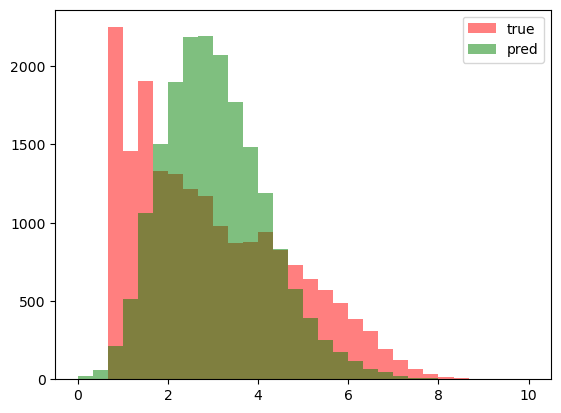

In [99]:
plt.hist(y_valid, bins=30, alpha=0.5, color="red", label="true", range=(0, 10))
plt.hist(
    rr_predictions, bins=30, alpha=0.5, color="green", label="pred", range=(0, 10)
)
plt.legend();

In [79]:
rr.fit(X_train_sparse, y)
rr_predictions = rr.predict(X_test_sparse)

In [88]:
submission = pd.read_csv(PATH_TO_SAMPLE_SUBMISSION, index_col="id")
submission['log_recommends'] = rr_predictions
submission.to_csv('submission1.csv')